# Style Transfer

[Got from this link](link)



##### Initialize and import etc

In [1]:
# To plot
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10) # TODO Look up
mpl.rcParams['axes.grid'] = False # TODO Look up

# Other stuff to use:
import numpy as np
from PIL import Image
import time
import functools

In [2]:
import numpy as np
import os
import time




In [3]:
# Backend:
# TODO Port this one later:
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend" 

import tensorflow as tf
import tensorflow.contrib.eager as tfe

In [4]:
# Keras stuff:
from tensorflow import keras
#import keras.applications as kapp
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K


In [5]:
# This is included in example. Trying without to see if it can work with plaid. Otherwise activate it again.
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [6]:
# Global variables to use:
content_path = 'images/content1.jpg'
style_path = 'images/style1.jpg'
MAX_SIZE = 512


#### Helper Functions to visualize input

In [7]:
def load_img(image_path, max_dim):
    # Load the img
    img = Image.open(image_path)
    
    # Get the largest side of the img
    long = max(img.size)
    
    # Get how much we need to scale the img
    scale = max_dim/long
    
    #Resize the img
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    
    # Convert the img to an array of some kind?
    # TODO Look up
    img = kp_image.img_to_array(img)
    
    # We need to broadcast the image array such that it has a batch dimension 
    # TODO Look up what that means
    img = np.expand_dims(img, axis=0)
    
    return img

In [8]:
def imshow(img, title=None):
    # Remove the batch dimensions
    # This is probably the thing we added with np.expand_dims in load_img above.
    out = np.squeeze(img, axis=0)
    
    #Normalize for display
    out = out.astype('uint8')
    
    plt.imshow(out)
    
    if title is not None:
        plt.title(title)
    plt.imshow(out)

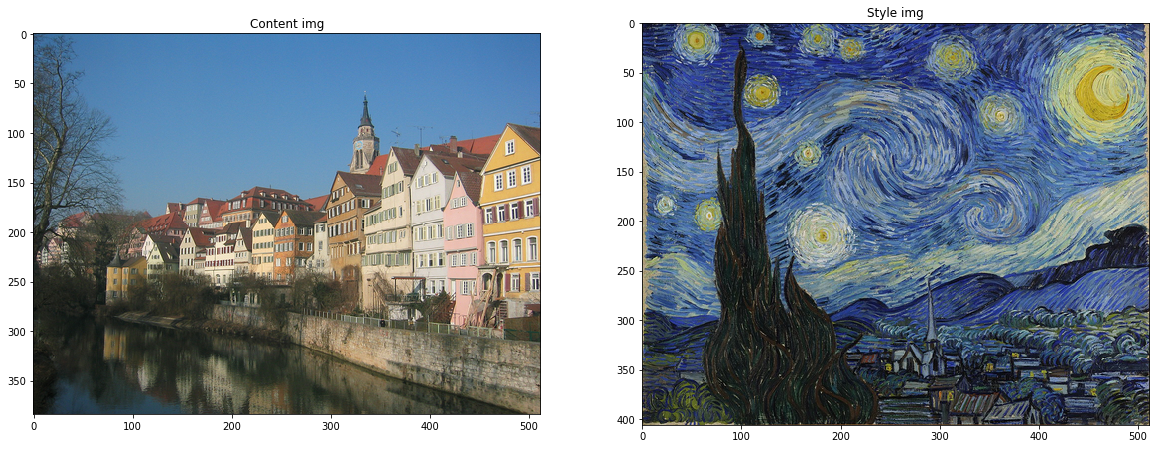

In [9]:
plt.figure(figsize=(20,20))

content = load_img(content_path, MAX_SIZE).astype('uint8')
style = load_img(style_path, MAX_SIZE).astype('uint8')

plt.subplot(1,2,1)
imshow(content, 'Content img')

plt.subplot(1,2,2)
imshow(style, 'Style img')
plt.show()

### Prepare the data
Below we will define the functions to prepare the data and model.

Pasted from tutorial:
- "We perform the same preprocessing process as are expected according to the VGG training process. VGG networks are trained on image with each channel normalized by `mean = [103.939, 116.779, 123.68]` and with channels BGR."

In [10]:
def load_and_process_img(img_path):
    # Get img
    img = load_img(img_path, MAX_SIZE)
    
    # Do the preprocessing
    img = keras.applications.vgg19.preprocess_input(img)
    
    return img

To be able to see the values from the optimization the inverse of the preprocessing above needs to be done. 
The preprocessing may take its values from anywhere between (-infinity) and infinity and to be able to view it we need values in each channel between 0-255.

In [11]:
def deprocess_img(processed_img):
    clone = processed_img.copy()
    
    """
    Seems that the format can be either [1, height, width, channel] OR [height, width, channel]
    This step removes the 1 if it's the former.
    """
    if len(clone.shape) == 4:
        clone = np.squeeze(clone, 0)
    
    assert len(clone.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    
    if len(clone.shape) != 3:
        raise ValueError('Invalid input image to deprocess')
        
    # Do the inverted of the preprocessing, ie. adding the values that it's normalized with
    clone[:, :, 0] += 103.939
    clone[:, :, 1] += 116.779
    clone[:, :, 2] += 123.68
    clone = clone[:, :, ::-1]
    
    # Make sure we only have valid values
    clone = np.clip(clone, 0, 255).astype('uint8')
    return clone
    
    

### Define content and style representations
_Stolen directly from tutorial_

In order to get both the content and style representations of our image, we will look at some intermediate layers within our model. As we go deeper into the model, these intermediate layers represent higher and higher order features. In this case, we are using the network architecture VGG19, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from our images. For an input image, we will try to match the corresponding style and content target representations at these intermediate layers. 

You may be wondering why these intermediate outputs within our pretrained image classification network allow us to define style and content representations. At a high level, this phenomenon can be explained by the fact that in order for a network to perform image classification (which our network has been trained to do), it must understand the image. This involves taking the raw image as input pixels and building an internal representation through transformations that turn the raw image pixels into a complex understanding of the features present within the image. This is also partly why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g., cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed in and the classification label is output, the model serves as a complex feature extractor; hence by accessing intermediate layers, we’re able to describe the content and style of input images.

Specifically we’ll pull out these intermediate layers from our network: 

In [12]:
# TODO Play around with these
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### Model stuff
- TODO: Try different models

###### Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  _Returns:_
  
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 

In [13]:
def get_model():
    """
    
    # Load the model:
    vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    # Get the layers specified above that corresponds to style and content
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    
    # Buidl the model
    return models.Model(vgg.input, model_outputs)"""

  # Load our model. We load pretrained VGG, trained on imagenet data
    vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    #vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    # Get output layers corresponding to style and content layers 
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    
    # Build model 
    return models.Model(vgg.input, model_outputs)

#### Computing __content loss__
_copied from tutorial_

We will actually add our content losses at each desired layer. This way, each iteration when we feed our input image through the model (which in eager is simply model(input_image)!) all the content losses through the model will be properly compute and because we are executing eagerly, all the gradients will be computed. 

In [14]:
def get_content_loss(base_content, target):
    # TODO Find out if Plaid has reduce_mean?
    return tf.reduce_mean(tf.square(base_content - target))

#### Computing **style loss**
_copied ffrom tutorial_

Computing style loss is a bit more involved, but follows the same principle, this time feeding our network the base input image and the style image. However, instead of comparing the raw intermediate outputs of the base input image and the style image, we instead compare the Gram matrices of the two outputs. 

Mathematically, we describe the style loss of the base input image, $x$, and the style image, $a$, as the distance between the style representation (the gram matrices) of these images. We describe the style representation of an image as the correlation between different filter responses given by the Gram matrix  $G^l$, where $G^l_{ij}$ is the inner product between the vectorized feature map $i$ and $j$ in layer $l$. We can see that $G^l_{ij}$ generated over the feature map for a given image represents the correlation between feature maps $i$ and $j$. 

To generate a style for our base input image, we perform gradient descent from the content image to transform it into an image that matches the style representation of the original image. We do so by minimizing the mean squared distance between the feature correlation map of the style image and the input image. The contribution of each layer to the total style loss is described by
$$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j}(G^l_{ij} - A^l_{ij})^2$$

where $G^l_{ij}$ and $A^l_{ij}$ are the respective style representation in layer $l$ of $x$ and $a$. $N_l$ describes the number of feature maps, each of size $M_l = height * width$. Thus, the total style loss across each layer is 
$$L_{style}(a, x) = \sum_{l \in L} w_l E_l$$
where we weight the contribution of each layer's loss by some factor $w_l$. In our case, we weight each layer equally ($w_l =\frac{1}{|L|}$)


### TODO Look up Gram matrices

In [15]:
def gram_matrix(input_tensor):
    
    # Make the image channels
    channels = int(input_tensor.shape[-1])
    
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    
    # Compute the matrix
    gram = tf.matmul(a,a, transpose_a = True)
    
    return gram / tf.cast(n, tf.float32)

In [16]:
def get_style_loss(base_style, gram_target):
    """Expects two images of dimension h, w, c"""
    
    # We scale the loss at a given layer by the size of the feature map and the number of filters
    height, width, channels = base_style.get_shape().as_list()
    
    # Get the gram matrix for the style
    gram_style = gram_matrix(base_style)
    
    return tf.reduce_mean(tf.square(gram_style - gram_target)) # / (4. * (channels ** 2) * (width * height) ** 2)
    # In the tutorial the lines after were commented, with those unused the height, width and channels are unused.
    # TODO Try adding them

### Style transfer

##### Run the Gradient Descent
__Copied from tutorial__

If you aren't familiar with gradient descent/backpropagation or need a refresher, you should definitely check out this [awesome resource](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent).

In this case, we use the [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)* optimizer in order to minimize our loss. We iteratively update our output image such that it minimizes our loss: we don't update the weights associated with our network, but instead we train our input image to minimize loss. In order to do this, we must know how we calculate our loss and gradients. 

\* Note that L-BFGS, which if you are familiar with this algorithm is recommended, isn’t used in this tutorial because a primary motivation behind this tutorial was to illustrate best practices with eager execution, and, by using Adam, we can demonstrate the autograd/gradient tape functionality with custom training loops.

## TODO
- Check Resources above
- Try different optimizers


In [17]:
def get_feature_representations(model, content_path, style_path):
    """Helper function to compute our content and style feature representations.

    This function will simply load and preprocess both the content and style 
    images from their path. Then it will feed them through the network to obtain
    the outputs of the intermediate layers. 
  
    Arguments:
        model: The model that we are using.
        content_path: The path to the content image.
        style_path: The path to the style image
    
    Returns:
        returns the style features and the content features. 
    """
    # Load our images in 
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
    
    # batch compute content and style features
    style_outputs = model(style_image)
    content_outputs = model(content_image)
    
    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

#### Computing loss and gradients
Here we use [**tf.GradientTape**](https://www.tensorflow.org/programmers_guide/eager#computing_gradients) to compute the gradient. It allows us to take advantage of the automatic differentiation available by tracing operations for computing the gradient later. It records the operations during the forward pass and then is able to compute the gradient of our loss function with respect to our input image for the backwards pass.

### TODO
- See if Plaid has something like gradientTape

In [18]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    """This function will compute the loss total loss.
    Arguments:
        model: The model that will give us access to the intermediate layers
        loss_weights: The weights of each contribution of each loss function. 
          (style weight, content weight, and total variation weight)
        init_image: Our initial base image. This image is what we are updating with 
          our optimization process. We apply the gradients wrt the loss we are 
          calculating to this image.
        gram_style_features: Precomputed gram matrices corresponding to the 
          defined style layers of interest.
        content_features: Precomputed outputs from defined content layers of 
          interest.
    Returns:
        returns the total loss, style loss, content loss, and total variational loss
    """
    
    style_weight, content_weight = loss_weights
    # Feed our init image through our model. This will give us the content and 
    # style representations at our desired layers. Since we're using eager
    # our model is callable just like any other function!
    model_outputs = model(init_image)
    
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    
    style_score = 0
    content_score = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
    # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    # TODO Look up what zip does
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
    
    style_score *= style_weight
    content_score *= content_weight
    
    # Get total loss
    loss = style_score + content_score 
    return loss, style_score, content_score

In [19]:
# Compute all the gradients:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

#### Optimization loop

##### TODO
- Play with weights
- Test iterations
- Test learningrates, beta, epsilon

In [20]:
# TODO Wad is dis?

import IPython.display

def run_style_transfer(content_path, 
                       style_path, 
                       num_iterations=1000, 
                       content_weight=1e3, 
                       style_weight=1e-2):
    # We don't want to train any layers, so set the trainable attribute to false:
    model = get_model()
    for layer in model.layers:
        layer.trainable = False
    
    # Get the style and content feature representations (from our specified intermediate layers)
    style_features, content_features = get_feature_representations(model, 
                                                                   content_path, 
                                                                   style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    
    # Set initial image
    init_image = load_and_process_img(content_path)
    
    init_image = tfe.Variable(init_image, dtype=tf.float32)
    
    # Create optimizer
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
    
    # For displaying intermediate images
    iter_count = 1
    
    # Store best reuslt
    best_loss, best_img = float('inf'), None
    
    # Create config
    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }
    
    # For displaying
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
    
    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time() 
        
        if loss < best_loss:
            # Update best loss and best image from total loss.
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())
            
        if i % display_interval == 0:
            start_time = time.time()
            
            # use the numpy() method to get the concrete numpy array
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
                  'style loss: {:.4e}, '
                  'content loss: {:.4e}, '
                  'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
        
        print('Total time: {:.4f}s'.format(time.time() - global_start))
        elapsed_time = (time.time() - global_start)
        time_per_iteration = max(1, elapsed_time)/max(i, 1)
        estimated_total_time = max(1, (time_per_iteration * num_iterations))/60
        
        print('On iteration: {} - Average per iteration: {} - ETA: {}'.format(i, 
                                                                              time_per_iteration, 
                                                                              estimated_total_time))
        IPython.display.clear_output(wait=True)
        plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    return best_img, best_loss

    
    

### Run the style transfer

In [ ]:
best, best_loss = run_style_transfer(content_path, style_path, num_iterations=1000)

Total time: 5663.8834s
On iteration: 981 - Average per iteration: 5.773581398614928 - ETA: 96.22635664358214


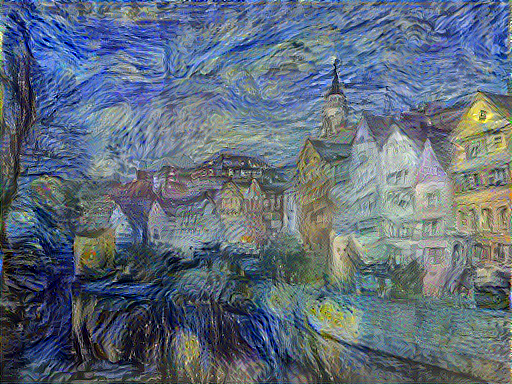

In [25]:
Image.fromarray(best)

In [26]:
def show_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(20, 10))
    content = load_img(content_path, MAX_SIZE) 
    style = load_img(style_path, MAX_SIZE)
    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')
    
    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')
    
      
    if show_large_final: 
        plt.figure(figsize=(20, 20))
        plt.imshow(best_img)
        plt.title('Output Image')
        plt.show()

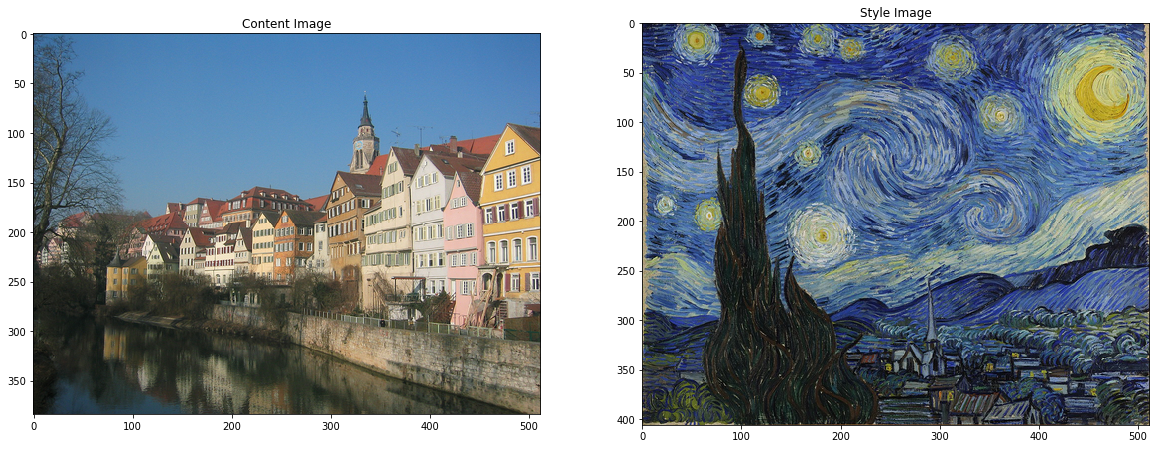

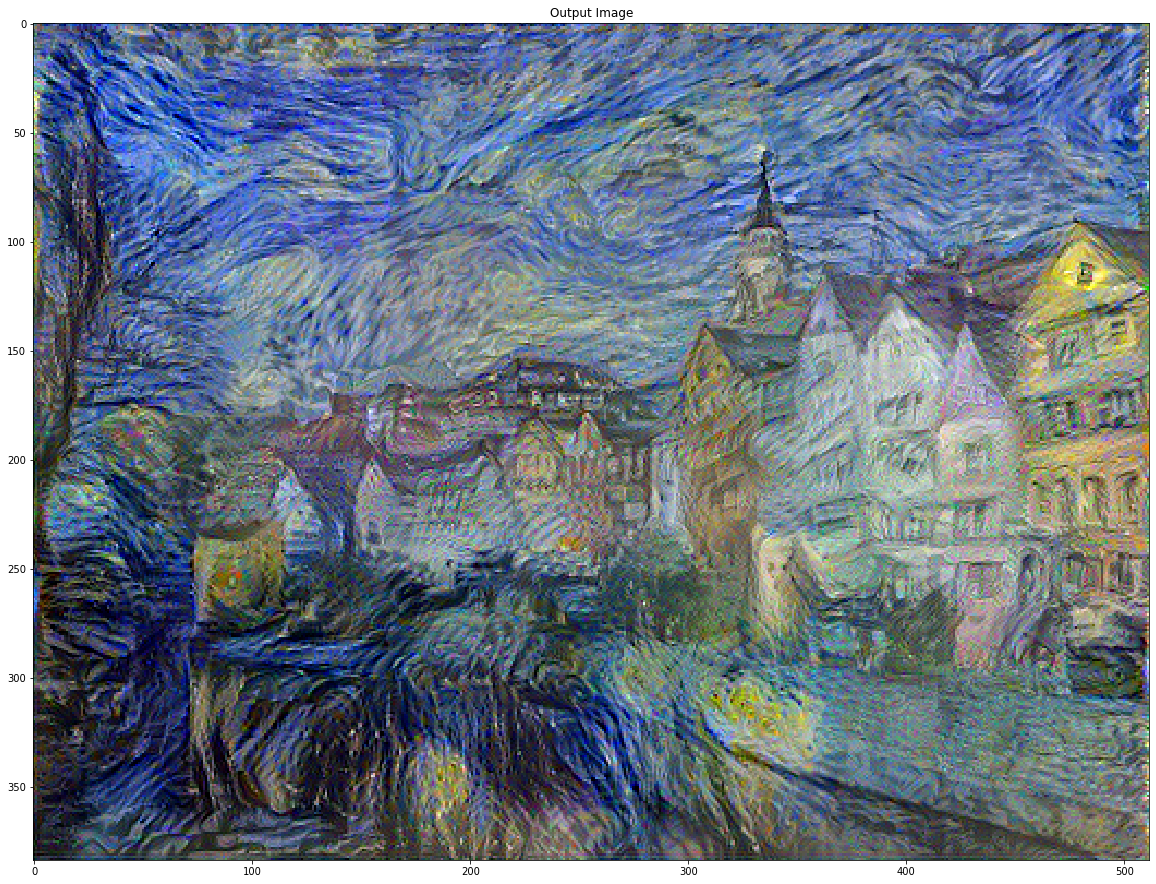

In [27]:
show_results(best, content_path, style_path)